# Analysis of the class distributions
(For a fully trained MLP)

In [1]:
# run this once to initialize the dataset
from experiment import fully_trained_MLP
fully_trained_MLP()

In [2]:
import json

with open("fullyTrained.json", "r") as file:
    raw_data = json.load(file)

data = raw_data
data

[[[0.9961512611359656,
   9.147084912832658e-07,
   0.0005556566819031709,
   0.00014322038716631477,
   5.883186824577204e-09,
   1.999814010118737e-08,
   6.382587975408969e-05,
   2.361357223812614e-06,
   3.977299639046465e-06,
   6.23663870538814e-05],
  [0.9831834907507753,
   5.0361107879346236e-08,
   8.35470360772049e-05,
   1.044836863874844e-06,
   7.898686343258272e-07,
   4.323182126871897e-05,
   2.269894733942377e-07,
   1.1994695650247792e-05,
   2.2190928616223826e-05,
   3.817975949085457e-05],
  [0.9993002513014183,
   1.1666667887249604e-08,
   0.0005196943935906684,
   9.124281018944595e-08,
   2.642921075539276e-06,
   4.906403475192802e-05,
   8.43282749220455e-08,
   0.0003133330951098516,
   1.1814152633333954e-06,
   4.111178472504881e-06],
  [0.9572062594465515,
   9.827935096740534e-08,
   8.9012100218158e-05,
   6.024845387451139e-07,
   7.63929528259455e-06,
   0.00017940281177383535,
   0.03803156315450361,
   5.377461465935039e-07,
   4.1955087483143443e

In [3]:
import pandas as pd

image0 = data[0] # classifications of images of 0

# Convert the list of lists into a DataFrame
df_image0 = pd.DataFrame(image0, columns=[f'Class{i}' for i in range(10)])

# Display the DataFrame
df_image0
print(max(df_image0.sum(1)))

1.883959122530467


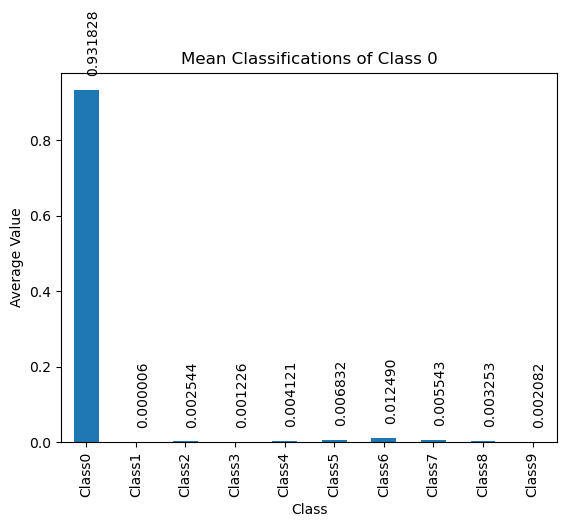

In [4]:
import matplotlib.pyplot as plt

average_values = df_image0.mean()

# Create a bar chart
ax = average_values.plot(kind='bar', xlabel='Class', ylabel='Average Value', title='Mean Classifications of Class 0')

# Add numerical values above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.6f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                rotation=90, ha='left', va='bottom', xytext=(0, 10), textcoords='offset points')

plt.show()

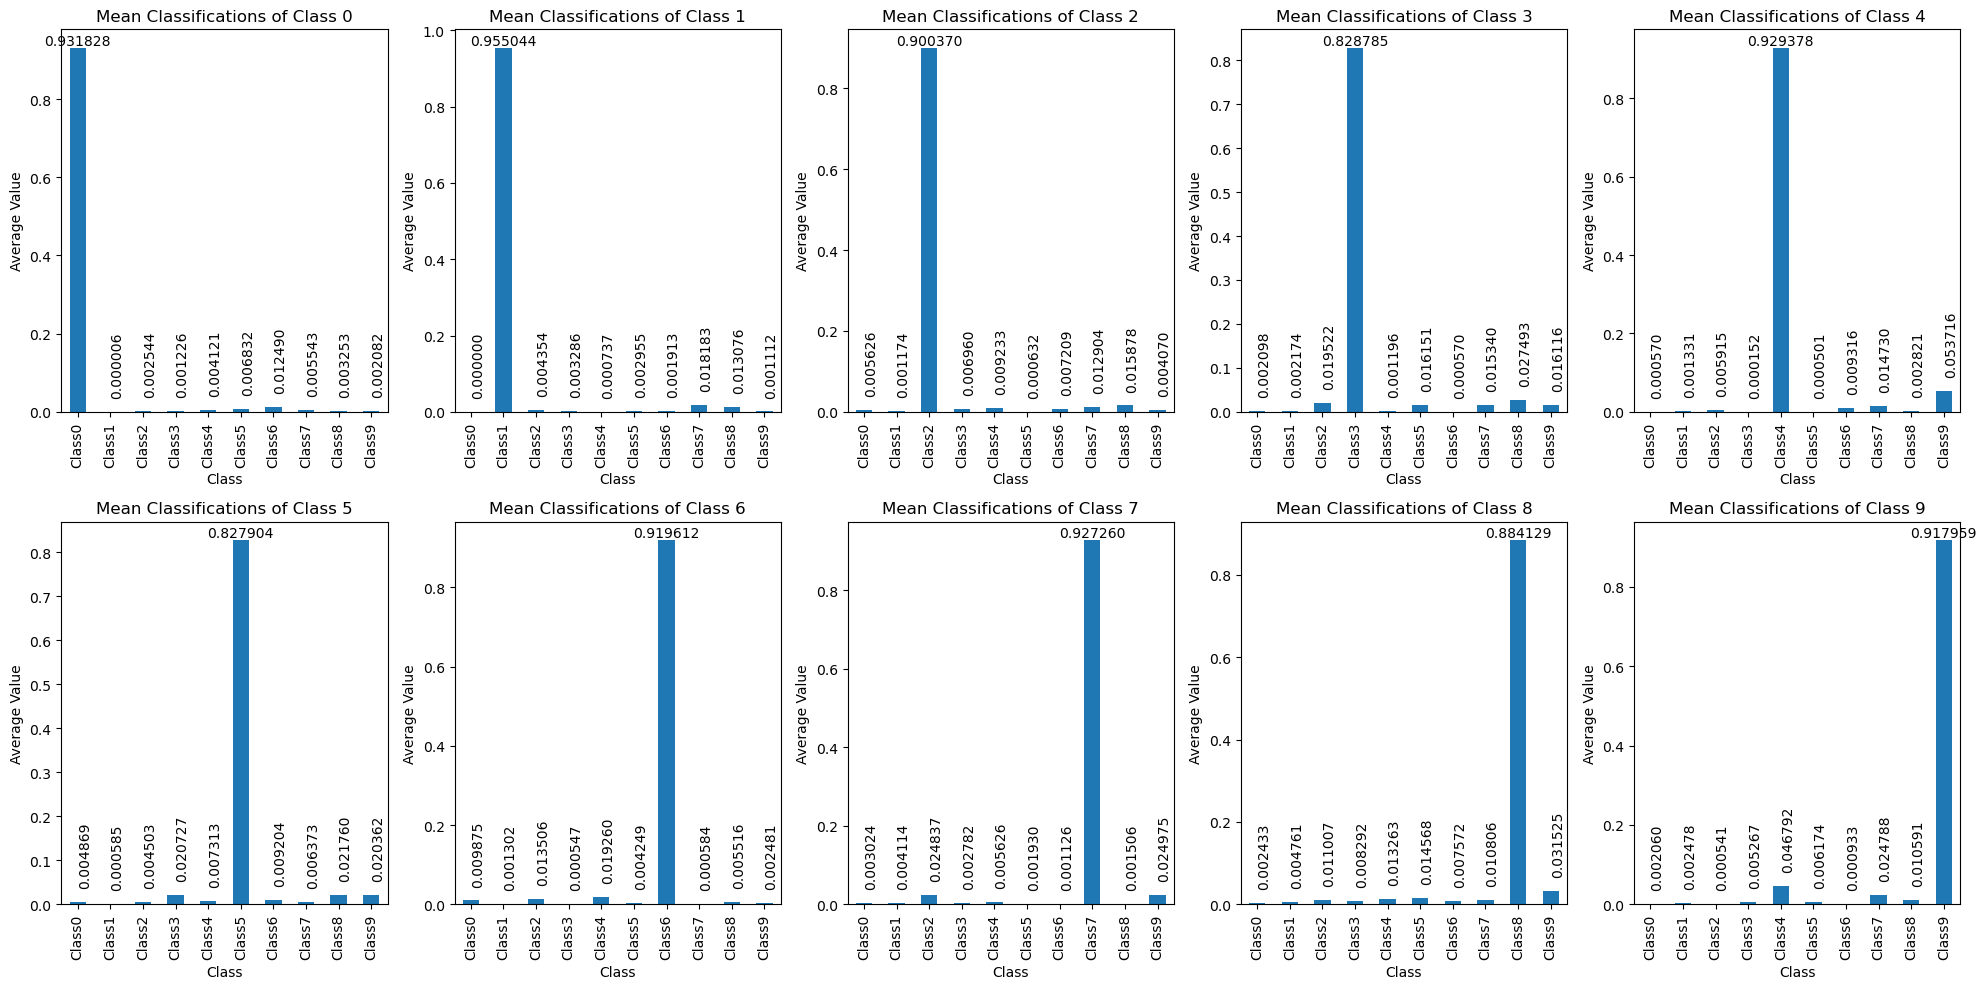

In [5]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

# Loop through each class
for i, ax in enumerate(axes.flatten()):
    # Grab the data for the input image class from the dataset
    input_class = data[i]
    # Shape a table to have a column for every classification and a row for every sample from the set of input images of the given class
    df_class = pd.DataFrame(input_class, columns=[f'Class{i}' for i in range(10)])  
    # Compute the average values of each classification
    average_values = df_class.mean()
    # Create a bar chart
    ax = average_values.plot(kind='bar', xlabel='Class', ylabel='Average Value', title=f'Mean Classifications of Class {i}', ax=ax)

    # Find the tallest bar
    tallest_bar = max(ax.patches, key=lambda p: p.get_height())

    # Add numerical values above each bar
    for p in ax.patches:
        if p == tallest_bar:
            ax.annotate(f'{p.get_height():.6f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        rotation=0, ha='center', va='top', xytext=(0, 10), textcoords='offset points')
        else:
            ax.annotate(f'{p.get_height():.6f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        rotation=90, ha='left', va='bottom', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

When a trained neural network classifies an image of a handwritten digit it outputs a list of certainties for each possible classification of the image. For example
```
[0.9969579251533486,
2.1089283227935008e-06,
0.00039071372990603215,
9.288141737066531e-06,
2.8067653986350715e-08,
2.8629378317280443e-05,
0.0003306717358557461,
1.89878288081726e-05,
2.4039755480831676e-06,
2.068496052912702e-05]
```
is an output from classifying a handwritten zero. The index with the highest certainty is the prediction it assigns to the image, but often other classifications have nonzero certainties as well. This distribution of certainties reflects the representation of reality encoded in the trained neural network.

While a well-trained neural network will always have the highest certainty for the correct classification, the second highest certainty can be thought of as closer to the correct classification in the neural network than the others. By averaging the certainties of each classification across many samples of each class of image, we can find which classes are proximate to each other in the neural network's encoding of reality. For example, images of 9's are given the most certainty of being 9's, but also have a comparatively high certainty of being 4's or 7's. This means that 9 is closer to 4 and 7 than to 0 or 2 in the neural network.

Note that class 4 is also comparatively close to class 9 but not to class 7. This is interesting. Would it be possible to plot these classes in n-dimensional space, where the distance from one to another is given by the certainty of images of the source class being classified as the destination class?

$$d(a, b) = \text{certainty of } a \text{ classified as } b$$

While we are discussing these using the analogy of distances, this is not a distance function, because $d(x, x) \neq 0 $, and $d(x, y) \neq d(y, x)$.

ChatGPT recommended the following options:
- Directed graphs let you directly display the asymmetry.
- Star-shaped MDS lets you fix a perspective (by centering on a chosen digit) while still trying to preserve other pairwise relationships.
- Radar charts are useful for comparing the output “profiles” of different digits.
- Standard embedding techniques (after symmetrization) can provide a global picture but may lose some directional information.

In [6]:
# Measure the assymetry of the distances
# put the average class values in an adjacency matrix
import numpy as np
mean_classes_values = []
for i in range(10):
    # Grab the data for the input image class from the dataset
    input_class = data[i]
    # container to hold the mean certainties for the class
    mean_certainties = []
    for j in range(10):
        # container to hold the raw certainty data for each classification 0-9
        class_certainties = []
        for sample in input_class:
            class_certainties.append(sample[j])
        # Compute the average certainty of each classification across all samples
        mean_certainties.append(np.mean(class_certainties))

    mean_classes_values.append(mean_certainties)

mean_classes_values


[[0.9318280181366624,
  6.4987295370786004e-06,
  0.002543536676000667,
  0.0012258861559155637,
  0.0041210571506728405,
  0.006831756169345165,
  0.012490327245198796,
  0.005542573133663214,
  0.0032533537055247177,
  0.002081745671228347],
 [4.674603697564958e-07,
  0.9550438180509838,
  0.0043537006136088905,
  0.0032860656397666684,
  0.0007365017540300409,
  0.00295499599065412,
  0.0019125572774185528,
  0.018182683561134172,
  0.013075729853776811,
  0.0011124554105343114],
 [0.005626010124526342,
  0.0011740989380311156,
  0.9003704261749174,
  0.006959787451922956,
  0.009233453994600994,
  0.0006323988940391532,
  0.007209380135031248,
  0.012904223625162626,
  0.015877547952564873,
  0.004069761435303404],
 [0.002098368759643107,
  0.0021736513830542684,
  0.019522201868824928,
  0.8287847303681561,
  0.001196089709859321,
  0.01615069161928909,
  0.0005701600971821267,
  0.015340064767687109,
  0.02749278685611895,
  0.01611629223925826],
 [0.0005704762473416469,
  0.0013

In [7]:
# use this adjacency matrix to compute the assymetry of the distances: say 9 to 4 and 4 to 9
import math
distances = []
for i in range(10):
    for j in range(10):
        if(i!=j):
            distances.append((1-mean_classes_values[i][j], 1-mean_classes_values[j][i]))

assymetry = [np.abs(a - b) for a, b in distances]
print(np.mean(assymetry))
print(np.sum(assymetry))
print(np.max(assymetry))
assymetry

0.0055615071850753095
0.5005356466567779
0.02093343635064604


[6.031269167316999e-06,
 0.0030824734485256355,
 0.0008724826037275202,
 0.0035505809033311575,
 0.0019627681308950207,
 0.0026149750595690913,
 0.002519045527788144,
 0.0008201981426864124,
 2.131628694890253e-05,
 6.031269167316999e-06,
 0.0031796016755777368,
 0.0011124142567123796,
 0.0005940957207690722,
 0.002370081587687367,
 0.0006106591704861941,
 0.014068351883754437,
 0.008314801792696502,
 0.0013652755350068713,
 0.0030824734485256355,
 0.0031796016755777368,
 0.012562414416901979,
 0.0033188948027347287,
 0.003870888837380404,
 0.0062964140258983115,
 0.011932946764651398,
 0.004870713484976141,
 0.0035291282363389964,
 0.0008724826037275202,
 0.0011124142567123796,
 0.012562414416901979,
 0.0010444266004995262,
 0.004576291122266762,
 2.2788819649788294e-05,
 0.01255812214382257,
 0.019201241717297313,
 0.010849656202851166,
 0.0035505809033311575,
 0.0005940957207690722,
 0.0033188948027347287,
 0.0010444266004995262,
 0.0068124008855257046,
 0.009943306196671386,
 0.009

It seems that there is an acceptably low level of assymetry, so we can will symmetrize the adjacency matrix and proceed with PCA analysis
# PCA analysis

In [8]:
# define the distance between classes to be 1 - certainty
distances = [[1-val for val in class_vals] for class_vals in mean_classes_values]
distances

[[0.06817198186333762,
  0.9999935012704629,
  0.9974564633239993,
  0.9987741138440844,
  0.9958789428493272,
  0.9931682438306548,
  0.9875096727548012,
  0.9944574268663368,
  0.9967466462944753,
  0.9979182543287717],
 [0.9999995325396303,
  0.04495618194901618,
  0.9956462993863912,
  0.9967139343602334,
  0.9992634982459699,
  0.9970450040093459,
  0.9980874427225814,
  0.9818173164388658,
  0.9869242701462232,
  0.9988875445894657],
 [0.9943739898754737,
  0.9988259010619689,
  0.09962957382508264,
  0.9930402125480771,
  0.990766546005399,
  0.9993676011059609,
  0.9927906198649687,
  0.9870957763748374,
  0.9841224520474351,
  0.9959302385646966],
 [0.9979016312403569,
  0.9978263486169457,
  0.9804777981311751,
  0.17121526963184386,
  0.9988039102901407,
  0.9838493083807109,
  0.9994298399028179,
  0.9846599352323129,
  0.972507213143881,
  0.9838837077607417],
 [0.9994295237526584,
  0.9986694025252009,
  0.9940854408081338,
  0.9998483368906402,
  0.07062185726484538,
  0

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# -------------------------------
# Step 0: Define Your Dissimilarity Matrix
# -------------------------------
# Replace the following with your actual 10x10 matrix of distances.
# Here we use a dummy matrix for illustration.
D = np.array(distances)
D

array([[0.06817198, 0.9999935 , 0.99745646, 0.99877411, 0.99587894,
        0.99316824, 0.98750967, 0.99445743, 0.99674665, 0.99791825],
       [0.99999953, 0.04495618, 0.9956463 , 0.99671393, 0.9992635 ,
        0.997045  , 0.99808744, 0.98181732, 0.98692427, 0.99888754],
       [0.99437399, 0.9988259 , 0.09962957, 0.99304021, 0.99076655,
        0.9993676 , 0.99279062, 0.98709578, 0.98412245, 0.99593024],
       [0.99790163, 0.99782635, 0.9804778 , 0.17121527, 0.99880391,
        0.98384931, 0.99942984, 0.98465994, 0.97250721, 0.98388371],
       [0.99942952, 0.9986694 , 0.99408544, 0.99984834, 0.07062186,
        0.99949912, 0.99068366, 0.98526996, 0.99717873, 0.94628359],
       [0.99513101, 0.99941509, 0.99549671, 0.97927302, 0.99268672,
        0.17209622, 0.99079634, 0.99362735, 0.97824036, 0.97963817],
       [0.99012465, 0.9986981 , 0.98649421, 0.99945263, 0.98074036,
        0.99575108, 0.08038795, 0.99941615, 0.9944836 , 0.99751876],
       [0.99697647, 0.99588567, 0.9751628

In [10]:
# -------------------------------
# Step 1: Symmetrize the Matrix
# -------------------------------
# Since PCA requires a symmetric (and ideally Euclidean) representation, we symmetrize D.
D_sym = (D + D.T) / 2
# use this adjacency matrix to compute the assymetry of the distances: say 9 to 4 and 4 to 9
import math
distances = []
for i in range(10):
    for j in range(10):
        if(i!=j):
            distances.append((D_sym[i][j], D_sym[j][i]))

assymetry = [np.abs(a - b) for a, b in distances]
print(np.mean(assymetry))
print(np.sum(assymetry))
print(np.max(assymetry))

0.0
0.0
0.0


Explained Variance Ratio: [0.12789001 0.1241525 ]


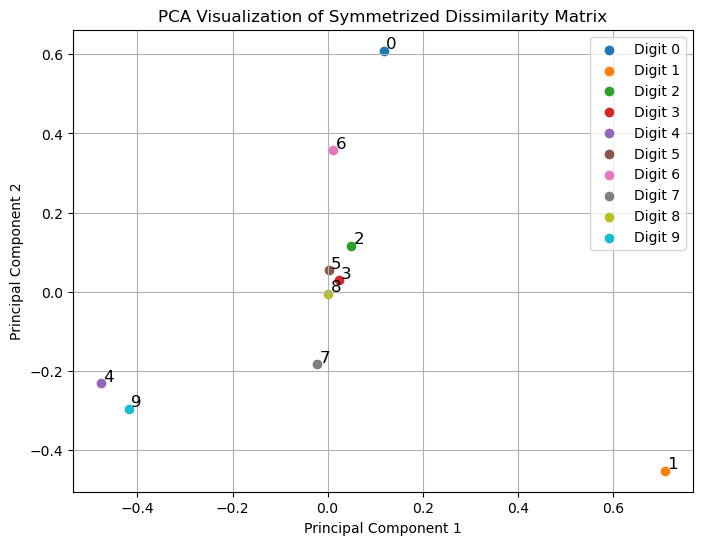

In [11]:
# -------------------------------
# Step 2: Form Feature Vectors from the Matrix Rows
# -------------------------------
# Each row of D_sym is a 10-dimensional vector that represents the relationship of that digit with all digits.
X = D_sym

# -------------------------------
# Step 3: Apply PCA to Reduce to 2 Dimensions
# -------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# -------------------------------
# Step 4: Visualize the 2D Representation
# -------------------------------
plt.figure(figsize=(8, 6))
for i in range(X_pca.shape[0]):
    plt.scatter(X_pca[i, 0], X_pca[i, 1], label=f"Digit {i}")
    # Annotate each point with its corresponding digit label
    plt.text(X_pca[i, 0] + 0.005, X_pca[i, 1] + 0.005, str(i), fontsize=12)
    
plt.title("PCA Visualization of Symmetrized Dissimilarity Matrix")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.legend()
plt.show()

PCA analysis only explains about 26% of the variation, but the results are consistent with human perception of these digits.
- 8 and 3 and very close to each other
- 2 and 5 are fairly close
- 9 and 4 and 7 are also close
- 0 and 1 are far apart
These are all consistent with the shapes of the numbers, meaning that the MLP is actually looking at shapes.